# Objetivo
> Atribuir um motorista à um cluster de entregas

# Métodos

> O algoritmo irá realizar iterações de acordo  com o número de clusters existentes e, a cada iteração, irá atribuir um entregador a um cluster de ordens.

> Para evitar que motoristas com `car_capacity == "Grande"` receba clusters de ordens de `volume == "Pequeno"` havendo motoristas com `car_capacity == "Pequeno"` disponíveis para realizá-las, a atribuição das ordens aos motoristas será realizada seguindo a sequência:
- 1º Cluster de ordens de `volume == "Grande"`
- 2º Cluster de ordens de `volume == "Medio"`
- 3º Cluster de ordens de `volume == "Pequeno"`
    
Dessa forma, os motoristas com `car_capacity == "Grande"` são os primeiros a serem selecionados, deixando menos motoristas elegíveis às entregas de `volume == "Pequeno"`, o que aumenta a probabilidade de motoristas com `car_capacity == "Pequeno"` receberem alguma ordem.

> Para atribuir um motorista à um cluster de ordens, o algoritmo seguirá os seguintes passos:
1. Selecionar os *motoristas elegíveis* sendo a regra de elgibilidade a seguinte:
     - Cluster de ordens de `volume == "Grande"`: Motoristas elegíveis: `car_capacity == "Grande"`
     - Cluster de ordens de `volume == "Medio"`: Motoristas elegíveis: `car_capacity in ["Grande", "Medio"]`
     - Cluster de ordens de `volume == "Pequeno"`: Motoristas elegíveis: `car_capacity in ["Grande", "Medio", "Pequeno"]`
2. Selecionar o motorista mais próximo do cluster
    - O motorista selecionado será o que, dentre os motoristas elegíveis ao cluster, seja o motorista com menor distância entre sua localização e algum dos pontos de origem do cluster.
    
Obs.: Eventualmente um cluster pode ter mais de um tipo de volume. Nesse caso será atribuído ao cluster o volume da ordem com maior volume

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import folium
import branca.colormap as cm

In [2]:
def plot_map(dfOrders, dfDeliverymen, column_cluster="cluster", icons_same_color=False, zoom_start=7):
    
    colors = ['blue','red','green','orange','pink','black','lightblue','purple','gray','cadetblue']
    colors_icons = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
                    'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
                    'gray', 'black', 'lightgray']
    
    cmap = cm.LinearColormap(colors=colors,
                             vmin=np.min(dfOrders[column_cluster]),
                             vmax=np.max(dfOrders[column_cluster]),
                             caption = 'Cluster Labels'
                            )

    center = [np.mean([np.mean(dfOrders.DeliveryPoint__Latitude__s), np.mean(dfOrders.CollectPoint__Latitude__s),]),
              np.mean([np.mean(dfOrders.DeliveryPoint__Longitude__s), np.mean(dfOrders.CollectPoint__Longitude__s),]),
             ]
    
    map_sp = folium.Map(location=center, zoom_start=zoom_start, width='100%', height="100%")

    for index, d in dfOrders.iterrows():
        
        location_origem = [d['CollectPoint__Latitude__s'], d['CollectPoint__Longitude__s']]
        location_destino = [d['DeliveryPoint__Latitude__s'], d['DeliveryPoint__Longitude__s']]

        folium.Marker(location_origem,
                      popup='origem',
                      icon=folium.Icon(color=colors_icons[d[column_cluster]] if icons_same_color else 'green'),
                     ).add_to(map_sp)

        folium.Marker(location_destino,
                      popup='destino',
                      icon=folium.Icon(color=colors_icons[d[column_cluster]] if icons_same_color else 'blue'),
                     ).add_to(map_sp)

        folium.PolyLine([location_origem, location_destino],
                        weight=2.5,
                        color=cmap(d[column_cluster]),
                       ).add_to(map_sp)
        
    for index, d in dfDeliverymen.iterrows():

        location = [d['DeliveryManLocation__Latitude__s'], d['DeliveryManLocation__Longitude__s']]
        
        folium.Marker(location,
                      popup=f'Delivery Man: {d["Id"]}',
                      icon=folium.Icon(color=colors_icons[-1-d["car_capacity__c"]]),
                     ).add_to(map_sp)


    legend_html =   f'''
                    <div style="position: fixed; 
                                bottom: 50px; right: 50px; width: 150px; height: 90px; 
                                border:2px solid grey; z-index:9999; font-size:14px;
                                ">&nbsp; Legend <br>
                                  &nbsp; Origin &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                                  &nbsp; Destination &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
                    </div>
                    <div style="position: fixed; 
                                bottom: 150px; right: 50px; width: 150px; height: 115px; 
                                border:2px solid grey; z-index:9999; font-size:14px;
                                ">&nbsp; Car Capacity <br>
                                  &nbsp; Grande &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{colors_icons[-1]}"></i><br>
                                  &nbsp; Medio &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{colors_icons[-2]}"></i><br>
                                  &nbsp; Pequeno &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{colors_icons[3]}"></i>
                    </div>
                    '''

    map_sp.get_root().html.add_child(folium.Element(legend_html))

    map_sp.add_child(cmap)
    
    display(map_sp)

In [37]:
deliverymen = pd.read_csv('.\\Bases\\Entregadores__c.csv')
deliverymen["car_capacity__c"] = np.where(deliverymen["car_capacity__c"] == "Alta", 0,
                                          np.where(deliverymen["car_capacity__c"] == "Média", 1,
                                                   np.where(deliverymen["car_capacity__c"] == "Baixa", 2,
                                                            -1
                                                           )
                                                  )
                                         )
deliverymen

,Id,Name,car_capacity__c,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s,Next_WorkDay__c
0,254705,Alexandre,1,-24.006472,-46.272175,True
1,284178,Eduardo,1,-23.115526,-46.552918,True
2,122019,Henrique,1,-23.407401,-46.758610,True
3,165215,Murilo,0,-23.415004,-46.897116,True
4,86788,Theo,0,-23.630328,-46.640746,True
5,96477,André,2,-23.595924,-46.669864,True
6,212140,Enrico,0,-23.554467,-46.308525,True
7,227795,Henry,0,-23.666131,-46.413293,True
8,82413,Nathan,1,-23.597327,-46.595990,True
9,253167,Thiago,2,-23.973751,-46.371917,True


In [21]:
order_clusters = pd.read_csv('.\\Bases\\SolicitacaoEntrega__c_with_clusters.csv')

order_clusters_g = order_clusters.loc[order_clusters["TamanhoPacote__c"] == 0]
order_clusters_m = order_clusters.loc[order_clusters["TamanhoPacote__c"] == 1]
order_clusters_p = order_clusters.loc[order_clusters["TamanhoPacote__c"] == 2]

# print("order_clusters")
# display(order_clusters.head())
# print("order_clusters_g")
# display(order_clusters_g.head())
# print("order_clusters_m")
# display(order_clusters_m.head())
# print("order_clusters_p")
display(order_clusters_p.head())

,Id,TamanhoPacote__c,CollectPoint__Latitude__s,CollectPoint__Longitude__s,DeliveryPoint__Latitude__s,DeliveryPoint__Longitude__s,CreatedDate,cluster
0,317bc187384c65775ea8f3b23aad4acf,2,-22.556606,-47.442603,-23.665931,-47.029936,2017-11-17 10:23:33,5
1,47999a7490ff2905f7ca3da2edcc9c52,2,-23.690136,-46.704876,-23.448542,-46.597961,2018-04-12 22:26:12,0
2,db8f21db0519c6ab351e3bbf641439ca,2,-23.500717,-46.589716,-22.869819,-48.456964,2018-04-20 19:36:34,4
3,8f815207602f16cdf25a3fb1858ca6be,2,-23.304322,-45.977171,-23.854365,-46.954536,2017-03-31 02:27:06,0
4,eaae3cf15cb2de079d33c44d3a8b2dc9,2,-23.736102,-46.441666,-23.582304,-46.403328,2018-02-19 22:00:34,0


# Passo a passo do algoritmo

In [26]:
clusters = np.unique(order_clusters_p["cluster"])
clusters

array([0, 1, 2, 4, 5, 7, 8, 9], dtype=int64)

In [38]:
eligible_deliverymen = deliverymen[deliverymen.isin({"car_capacity__c":[0,1,2]})["car_capacity__c"]]
eligible_deliverymen

,Id,Name,car_capacity__c,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s,Next_WorkDay__c
0,254705,Alexandre,1,-24.006472,-46.272175,True
1,284178,Eduardo,1,-23.115526,-46.552918,True
2,122019,Henrique,1,-23.407401,-46.758610,True
3,165215,Murilo,0,-23.415004,-46.897116,True
4,86788,Theo,0,-23.630328,-46.640746,True
5,96477,André,2,-23.595924,-46.669864,True
6,212140,Enrico,0,-23.554467,-46.308525,True
7,227795,Henry,0,-23.666131,-46.413293,True
8,82413,Nathan,1,-23.597327,-46.595990,True
9,253167,Thiago,2,-23.973751,-46.371917,True


In [24]:
order_clusters_p

,Id,TamanhoPacote__c,CollectPoint__Latitude__s,CollectPoint__Longitude__s,DeliveryPoint__Latitude__s,DeliveryPoint__Longitude__s,CreatedDate,cluster
0,317bc187384c65775ea8f3b23aad4acf,2,-22.556606,-47.442603,-23.665931,-47.029936,2017-11-17 10:23:33,5
1,47999a7490ff2905f7ca3da2edcc9c52,2,-23.690136,-46.704876,-23.448542,-46.597961,2018-04-12 22:26:12,0
2,db8f21db0519c6ab351e3bbf641439ca,2,-23.500717,-46.589716,-22.869819,-48.456964,2018-04-20 19:36:34,4
3,8f815207602f16cdf25a3fb1858ca6be,2,-23.304322,-45.977171,-23.854365,-46.954536,2017-03-31 02:27:06,0
4,eaae3cf15cb2de079d33c44d3a8b2dc9,2,-23.736102,-46.441666,-23.582304,-46.403328,2018-02-19 22:00:34,0
5,30dbb7bb7d4c27c3efd6ab7c9c27f9d0,2,-22.557467,-47.412520,-23.490995,-46.715180,2018-04-03 11:53:18,5
6,2343d4a98379202b11d3ec66c322ab57,2,-22.411500,-48.456051,-23.620190,-46.625411,2018-03-22 18:07:42,2
7,49287801ce45d679f7744b39f6fb6131,2,-23.516334,-46.546652,-23.554750,-46.500701,2018-05-07 09:15:27,0
8,c3a3138b83444e2e6c24b0bdd327bd30,2,-22.824622,-47.264056,-23.636334,-46.648851,2017-12-11 21:59:48,5
10,84300a0c4b27875cb77c89f5383df360,2,-23.612053,-46.607835,-23.602448,-46.588820,2017-11-18 13:20:25,0


In [27]:
for i in clusters:
    print(f"cluster {i}")
    plot_map(order_clusters_p.query(f"cluster == {i}"), eligible_deliverymen, zoom_start=9)

cluster 0


cluster 1


cluster 2


cluster 4


cluster 5


cluster 7


cluster 8


cluster 9


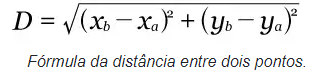

`distAB = np.sqrt((xA-xB)**2) + ((yA-yB)**2)`

In [39]:
for i in clusters:
    df = pd.merge(order_clusters_p.query(f"cluster == {i}"), eligible_deliverymen, how='cross')

    xA_less_xB = df["CollectPoint__Latitude__s"]-df["DeliveryManLocation__Latitude__s"]
    yA_less_yB = df["CollectPoint__Longitude__s"]-df["DeliveryManLocation__Longitude__s"]
    df["distance"] = np.sqrt((xA_less_xB**2) + (yA_less_yB**2))

    nearest_deliveryman = df.sort_values("distance", ascending=True)[:1][["Id_y", "distance", "cluster"]]
    id_nearest_deliveryman = nearest_deliveryman.rename(columns={"Id_y":"Id"})["Id"].values[0]
    
    print(f"Cluster: {i} Deliveryman: {id_nearest_deliveryman}")
    
    eligible_deliverymen = eligible_deliverymen.query(f"Id != {id_nearest_deliveryman}")

Cluster: 0 Deliveryman: 82413
Cluster: 1 Deliveryman: 96477
Cluster: 2 Deliveryman: 165215
Cluster: 4 Deliveryman: 86788
Cluster: 5 Deliveryman: 284178
Cluster: 7 Deliveryman: 122019
Cluster: 8 Deliveryman: 212140
Cluster: 9 Deliveryman: 227795


In [40]:
eligible_deliverymen

,Id,Name,car_capacity__c,DeliveryManLocation__Latitude__s,DeliveryManLocation__Longitude__s,Next_WorkDay__c
0,254705,Alexandre,1,-24.006472,-46.272175,True
9,253167,Thiago,2,-23.973751,-46.371917,True


# Desenvolvendo aplicação

In [60]:
deliverymen = pd.read_csv('.\\Bases\\Entregadores__c.csv')
deliverymen["car_capacity__c"] = np.where(deliverymen["car_capacity__c"] == "Alta", 0,
                                          np.where(deliverymen["car_capacity__c"] == "Média", 1,
                                                   np.where(deliverymen["car_capacity__c"] == "Baixa", 2,
                                                            -1
                                                           )
                                                  )
                                         )

order_clusters = pd.read_csv('.\\Bases\\SolicitacaoEntrega__c_with_clusters.csv')
order_clusters["id_deliveryman"] = -1
order_clusters.id_deliveryman = order_clusters.id_deliveryman.astype("int")

clusters = np.unique(order_clusters_p["cluster"])

def nearest_deliveryman(order_clusters, eligible_deliverymen):
    df = pd.merge(order_clusters, eligible_deliverymen, how='cross')
    
    xA_less_xB = df["CollectPoint__Latitude__s"]-df["DeliveryManLocation__Latitude__s"]
    yA_less_yB = df["CollectPoint__Longitude__s"]-df["DeliveryManLocation__Longitude__s"]
    df["distance"] = np.sqrt((xA_less_xB**2) + (yA_less_yB**2))

    nearest_deliveryman = (
        df.sort_values("distance", ascending=True)[:1][["Id_y", "distance", "cluster"]]
        .rename(columns={"Id_y":"Id"})
    )
    
    id_deliveryman = nearest_deliveryman["Id"].values[0]
    
    return id_deliveryman

for i in range(3):
    
    clusters = np.unique(order_clusters.query(f"TamanhoPacote__c == {i}")["cluster"])
    eligible_deliverymen = deliverymen[deliverymen.isin({"car_capacity__c":[0,1,2][:i+1]})["car_capacity__c"]]
    
    for j in clusters:
        id_nearest_deliveryman = nearest_deliveryman(order_clusters.query(f"cluster == {j}"),
                                                     eligible_deliverymen)
        
        eligible_deliverymen = eligible_deliverymen.query(f"Id != {id_nearest_deliveryman}")
        deliverymen = deliverymen.query(f"Id != {id_nearest_deliveryman}")
        
        order_clusters["id_deliveryman"] = np.where(order_clusters["cluster"] == j,
                                                    id_nearest_deliveryman,
                                                    order_clusters["id_deliveryman"])

In [61]:
# order_clusters.id_deliveryman = order_clusters.id_deliveryman.astype("int")
order_clusters[["cluster", "id_deliveryman"]].drop_duplicates().sort_values(["cluster", "id_deliveryman"])

,cluster,id_deliveryman
1,0,96477
18,1,122019
6,2,165215
28,3,82413
2,4,227795
0,5,284178
9,6,86788
44,7,212140
40,8,253167
16,9,254705
